In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from scipy.spatial import distance
from scipy.interpolate import Rbf

# For interactive maps
import folium
from folium.plugins import HeatMap

print("Libraries imported successfully!")

Libraries imported successfully!


In [8]:
def load_shapefile(file_path):
    """Load and return a shapefile as a GeoDataFrame."""
    if not os.path.exists(file_path):
        print(f"Warning: File {file_path} does not exist!")
        return None
    
    try:
        gdf = gpd.read_file(file_path)
        print(f"Loaded {file_path} with {len(gdf)} features")
        return gdf
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def load_raster(file_path):
    """Load and return a raster file."""
    if not os.path.exists(file_path):
        print(f"Warning: File {file_path} does not exist!")
        return None
    
    try:
        with rasterio.open(file_path) as src:
            data = src.read()
            meta = src.meta.copy()
        print(f"Loaded {file_path} with shape {data.shape}")
        return data, meta
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

def clip_raster_with_boundary(raster_data, raster_meta, boundary_gdf):
    """Clip a raster with a boundary."""
    try:
        # Ensure boundary is in the same CRS as the raster
        boundary_crs = boundary_gdf.crs
        raster_crs = rasterio.crs.CRS.from_string(raster_meta['crs'])
        
        if boundary_crs != raster_crs:
            boundary_gdf = boundary_gdf.to_crs(raster_crs)
        
        # Get geometry as GeoJSON for masking
        geoms = boundary_gdf.geometry.values
        
        # Create a virtual raster source
        with rasterio.io.MemoryFile() as memfile:
            with memfile.open(**raster_meta) as src:
                src.write(raster_data)
                clipped_data, clipped_transform = mask(src, geoms, crop=True)
            
            # Update metadata
            clipped_meta = raster_meta.copy()
            clipped_meta.update({
                "height": clipped_data.shape[1],
                "width": clipped_data.shape[2],
                "transform": clipped_transform
            })
        
        return clipped_data, clipped_meta
    except Exception as e:
        print(f"Error clipping raster: {e}")
        return raster_data, raster_meta

def display_raster(raster_data, raster_meta, band=0, title="", cmap="viridis"):
    """Display a raster band with proper styling."""
    if raster_data is None or raster_meta is None:
        print("Cannot display: Raster data or metadata is None")
        return
    
    plt.figure(figsize=(12, 10))
    
    if band >= raster_data.shape[0]:
        print(f"Band {band} out of range. Raster has {raster_data.shape[0]} bands.")
        band = 0
    
    # Create the plot
    show(raster_data[band], transform=raster_meta['transform'], cmap=cmap)
    plt.colorbar(label=f"Band {band} Value")
    plt.title(title)
    plt.tight_layout()
    plt.show()

Loaded data/fire13_19.shp with 197 features
Loaded data/fire20_23.shp with 70 features
Loaded data/pa_boundary.shp with 6 features
Combined fire events: 267
Fire events 2013-2022: 216
Fire events 2022 only: 4
Fire events March 2023: 51


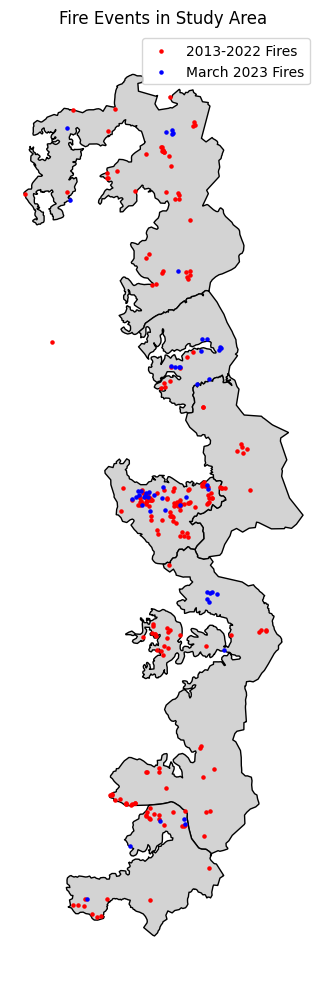

In [3]:
data_dir = "data"

# Load fire event datasets (2013-2019 and 2020-2023)
fire13_19 = load_shapefile(os.path.join(data_dir, "fire13_19.shp"))
fire20_23 = load_shapefile(os.path.join(data_dir, "fire20_23.shp"))

# Load study area boundary
study_area = load_shapefile(os.path.join(data_dir, "pa_boundary.shp"))

# Combine fire events (equivalent to the merge in the JS code)
if fire13_19 is not None and fire20_23 is not None:
    fire13_23 = pd.concat([fire13_19, fire20_23], ignore_index=True)
    print(f"Combined fire events: {len(fire13_23)}")
    
    # Filter out 2023 events (similar to the JS code)
    if 'acq_date' in fire13_23.columns:
        fire13_22 = fire13_23[~fire13_23['acq_date'].astype(str).str.contains('-2023')]
        fire2022 = fire13_23[fire13_23['acq_date'].astype(str).str.contains('2022')]
        fire_march_2023 = fire13_23[fire13_23['acq_date'].astype(str).str.contains('2023')]
        
        print(f"Fire events 2013-2022: {len(fire13_22)}")
        print(f"Fire events 2022 only: {len(fire2022)}")
        print(f"Fire events March 2023: {len(fire_march_2023)}")
        
        # Plot the fire events
        if study_area is not None:
            plt.figure(figsize=(12, 10))
            
            # Plot boundary
            study_area.plot(ax=plt.gca(), color='lightgrey', edgecolor='black')
            
            # Plot fire events
            fire13_22.plot(ax=plt.gca(), color='red', markersize=5, label='2013-2022 Fires')
            fire_march_2023.plot(ax=plt.gca(), color='blue', markersize=5, label='March 2023 Fires')
            
            plt.title('Fire Events in Study Area')
            plt.legend()
            plt.axis('off')
            plt.tight_layout()
            plt.show()
    else:
        print("Warning: 'acq_date' column not found in fire data")
else:
    print("Cannot proceed without fire event data")


Loaded data/inputResampled.tif with shape (40, 2912, 944)
Input raster has 40 bands


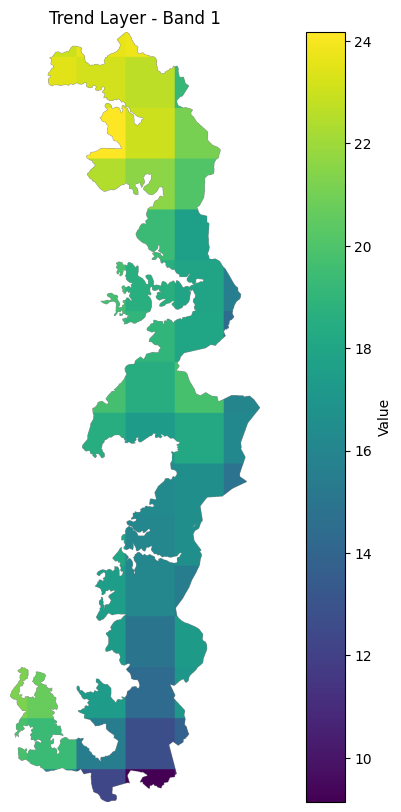

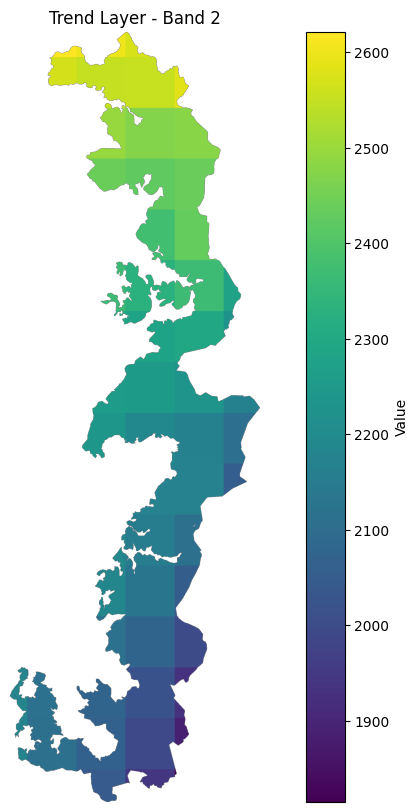

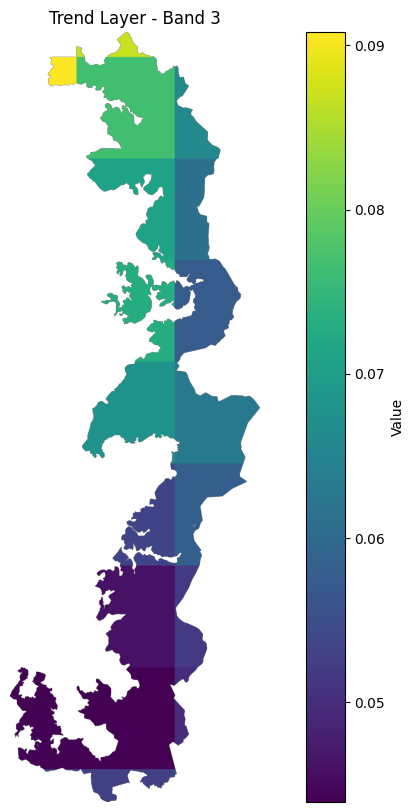

In [5]:
# Load the inputResampled.tif file (trend layers from TrendFire.js)
input_resampled, input_meta = load_raster(os.path.join(data_dir, "inputResampled.tif"))

if input_resampled is not None and input_meta is not None:
    print(f"Input raster has {input_resampled.shape[0]} bands")
    
    # Display the first few bands to understand the data
    for band_idx in range(min(3, input_resampled.shape[0])):
        plt.figure(figsize=(12, 10))
        plt.imshow(input_resampled[band_idx], cmap="viridis")
        plt.colorbar(label='Value')
        plt.title(f"Trend Layer - Band {band_idx+1}")
        plt.axis('off')
        plt.show()
else:
    print("Input raster (inputResampled.tif) not found.")
    print("This file contains 14 trend layers representing vegetation, burn indices, and meteorological parameters.")
    print("Download from: https://www.dropbox.com/scl/fi/ena1qfeqv5ppshluop8kt/inputResampled.tif")

In [13]:
# Load the road.tif file
road_data, road_meta = load_raster(os.path.join(data_dir, "road.tif"))

if road_data is not None and road_meta is not None:
    print("Road data loaded successfully")
    
    # Clip to study area if available
    if study_area is not None:
        road_data, road_meta = clip_raster_with_boundary(road_data, road_meta, study_area)
        print("Road data clipped to study area")
    
    # Display the road data
    display_raster(road_data, road_meta, band=0, title="Road Network", cmap="binary")
else:
    print("Road data (road.tif) not found")
    print("This layer was developed separately using QGIS and python")

Error loading data/road.tif: 'data/road.tif' not recognized as being in a supported file format.
Road data (road.tif) not found
This layer was developed separately using QGIS and python


Generating random points for non-fire locations...
Generated 62 random points within study area
After filtering: 62 non-fire points


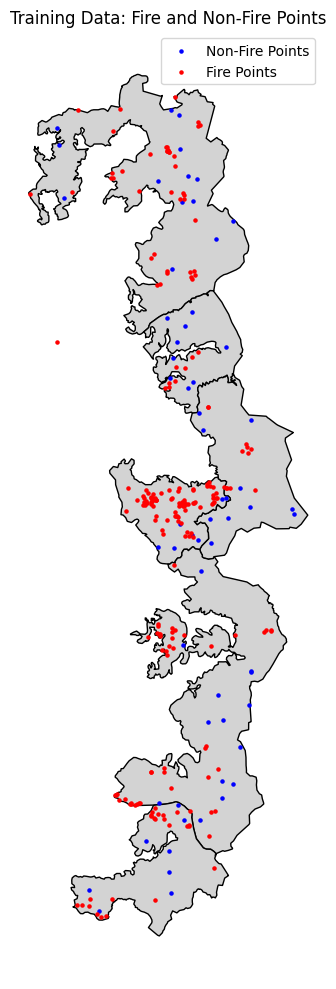

Low risk fire points: 31
Moderate risk fire points: 70
High risk fire points: 64
Total training points: 126


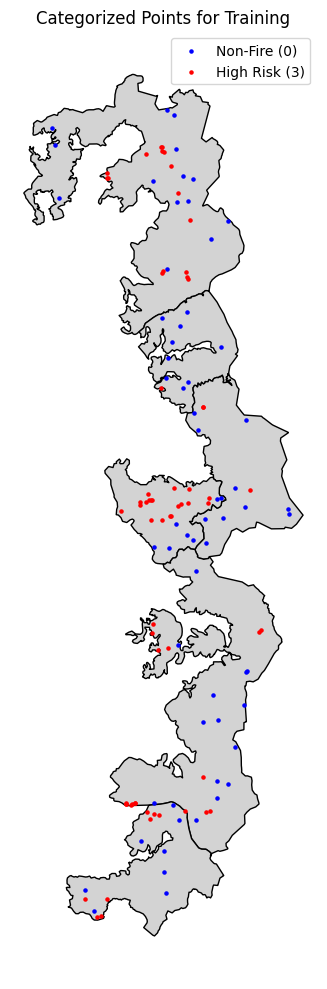

In [21]:
# CELL 15: Generate random points and prepare training data

# This cell corresponds to the random points generation section in FireVulnerability.js
try:
    if study_area is not None and 'fire13_22' in locals():
        # Generate random points across the entire study area
        print("Generating random points for non-fire locations...")
        
        # Create a bounding box from the study area
        bounds = study_area.total_bounds
        
        # Generate 200 random points within the bounding box
        random_x = np.random.uniform(bounds[0], bounds[2], 200)
        random_y = np.random.uniform(bounds[1], bounds[3], 200)
        
        # Create a GeoDataFrame with these points
        from shapely.geometry import Point
        random_pts = gpd.GeoDataFrame(
            geometry=[Point(x, y) for x, y in zip(random_x, random_y)],
            crs=study_area.crs
        )
        
        # Filter to ensure they're within the study area boundary
        random_pts = gpd.sjoin(random_pts, study_area, predicate='within', how='inner')
        
        # Remove problematic columns that might cause join issues later
        cols_to_drop = [col for col in random_pts.columns if col.startswith('index_')]
        if cols_to_drop:
            random_pts = random_pts.drop(columns=cols_to_drop)
            
        print(f"Generated {len(random_pts)} random points within study area")
        
        # Now filter out points that are too close to fire points
        
        # Convert to a projected CRS if the current one is geographic
        if study_area.crs.is_geographic:
            # Choose an appropriate projected CRS for your study area
            # UTM is a good choice - this is approximately UTM Zone 43N for Goa, India
            projected_crs = 'EPSG:32643'  # UTM Zone 43N
            random_pts_proj = random_pts.to_crs(projected_crs)
            fire13_22_proj = fire13_22.to_crs(projected_crs)
            
            # Now create the buffer in the projected CRS (100 meters)
            buffer_size = 100  # meters
            
            # Create a buffer around each fire point
            fire_buffers = fire13_22_proj.copy()
            fire_buffers['geometry'] = fire13_22_proj.geometry.buffer(buffer_size)
            
            # Use a different approach to find non-fire points
            # Create a spatial index for faster operations
            sindex = fire_buffers.sindex
            
            # For each random point, check if it intersects with any fire buffer
            non_fire_indices = []
            for idx, point in random_pts_proj.iterrows():
                # Query spatial index to find potential fire buffers this point might intersect with
                possible_matches_index = list(sindex.intersection(point.geometry.bounds))
                possible_matches = fire_buffers.iloc[possible_matches_index]
                
                # Check if this point intersects with any fire buffer
                if not any(possible_matches.geometry.intersects(point.geometry)):
                    non_fire_indices.append(idx)
            
            # Get the non-fire points
            non_fire_pts = random_pts_proj.loc[non_fire_indices].copy()
            
            # Convert back to original CRS
            non_fire_pts = non_fire_pts.to_crs(study_area.crs)
            
        else:
            # If already in projected CRS, proceed with buffer
            buffer_size = 100  # meters
            
            # Create a buffer around each fire point
            fire_buffers = fire13_22.copy()
            fire_buffers['geometry'] = fire13_22.geometry.buffer(buffer_size)
            
            # Use a different approach to find non-fire points
            # Create a spatial index for faster operations
            sindex = fire_buffers.sindex
            
            # For each random point, check if it intersects with any fire buffer
            non_fire_indices = []
            for idx, point in random_pts.iterrows():
                # Query spatial index to find potential fire buffers this point might intersect with
                possible_matches_index = list(sindex.intersection(point.geometry.bounds))
                possible_matches = fire_buffers.iloc[possible_matches_index]
                
                # Check if this point intersects with any fire buffer
                if not any(possible_matches.geometry.intersects(point.geometry)):
                    non_fire_indices.append(idx)
            
            # Get the non-fire points
            non_fire_pts = random_pts.loc[non_fire_indices].copy()
        
        # Limit to 90 points and add risk label
        non_fire_pts = non_fire_pts.head(90)
        non_fire_pts['RiskNumeric'] = 0  # Label as non-fire (low risk)
        
        print(f"After filtering: {len(non_fire_pts)} non-fire points")
        
        # Plot the sampled points
        plt.figure(figsize=(12, 10))
        study_area.plot(ax=plt.gca(), color='lightgrey', edgecolor='black')
        non_fire_pts.plot(ax=plt.gca(), color='blue', markersize=5, label='Non-Fire Points')
        fire13_22.plot(ax=plt.gca(), color='red', markersize=5, label='Fire Points')
        
        plt.title('Training Data: Fire and Non-Fire Points')
        plt.legend()
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Now categorize fire points based on Delta T as in the JS code
        if 'Delta T' in fire13_22.columns:
            # Create low, moderate, and high risk categories
            low_risk = fire13_22[fire13_22['Delta T'].between(0, 25)].copy()
            low_risk['RiskCategory'] = 'Low Risk'
            low_risk['RiskNumeric'] = 1
            
            moderate_risk = fire13_22[fire13_22['Delta T'].between(25, 35)].copy()
            moderate_risk['RiskCategory'] = 'Moderate Risk'
            moderate_risk['RiskNumeric'] = 2
            moderate_risk = moderate_risk.head(70)  # Limit as in JS
            
            high_risk = fire13_22[fire13_22['Delta T'] >= 35].copy()
            high_risk['RiskCategory'] = 'High Risk' 
            high_risk['RiskNumeric'] = 3
            
            print(f"Low risk fire points: {len(low_risk)}")
            print(f"Moderate risk fire points: {len(moderate_risk)}")
            print(f"High risk fire points: {len(high_risk)}")
            
            # Merge just non-fire and high risk for binary classification
            # This matches the JS code which only uses noFire.merge(highRisk)
            categorized_points = pd.concat([non_fire_pts, high_risk])
            
            print(f"Total training points: {len(categorized_points)}")
            
            # Plot the categorized points
            plt.figure(figsize=(12, 10))
            study_area.plot(ax=plt.gca(), color='lightgrey', edgecolor='black')
            
            # Plot each category
            for category, color, label in zip(
                [0, 3], 
                ['blue', 'red'],
                ['Non-Fire (0)', 'High Risk (3)']
            ):
                subset = categorized_points[categorized_points['RiskNumeric'] == category]
                if len(subset) > 0:
                    subset.plot(ax=plt.gca(), color=color, markersize=5, label=label)
            
            plt.title('Categorized Points for Training')
            plt.legend()
            plt.axis('off')
            plt.tight_layout()
            plt.show()
        else:
            print("Warning: 'Delta T' column not found in fire data")
            categorized_points = pd.concat([non_fire_pts, fire13_22])
            categorized_points.loc[categorized_points['RiskNumeric'].isna(), 'RiskNumeric'] = 1
    else:
        print("Cannot generate random points without study area boundary and fire data")
except Exception as e:
    print(f"Error generating training points: {e}")

Extracting raster values at training points...
Input raster shape: (40, 2912, 944), CRS: EPSG:3857
Points count: 126, CRS: EPSG:4326
Raster CRS: EPSG:3857
Points CRS: EPSG:4326
Reprojecting points from EPSG:4326 to EPSG:3857
Successfully sampled 126 out of 126 points

NaN counts per column:
geometry        0
Shape_Leng     64
Shape_Area     64
Name           64
RiskNumeric     0
               ..
band_35         0
band_36         0
band_37         0
band_38         0
band_39         0
Length: 65, dtype: int64
After removing NaN values: 119 of 126 points remain

Sample of the training data:


,geometry,Shape_Leng,Shape_Area,Name,RiskNumeric,bright_ti5,bright_ti4,acq_time,frp,Delta T,...,band_30,band_31,band_32,band_33,band_34,band_35,band_36,band_37,band_38,band_39
1,POINT (8261046.148 1687053.48),0.0,0.0,Cotigaon WLS,0,NaN,NaN,NaN,NaN,NaN,...,2.158347,116.887054,2020.793701,-0.010756,0.675415,-0.136112,32.900528,0.052642,21.622280,325.735016
3,POINT (8269121.273 1703992.482),0.0,0.0,Netravali WLS,0,NaN,NaN,NaN,NaN,NaN,...,-32.076859,89.234467,2545.909912,-0.008131,0.735141,-0.104667,32.834415,0.036715,20.826221,57.634197
8,POINT (8273698.954 1723359.797),0.0,0.0,Mollem NP,0,NaN,NaN,NaN,NaN,NaN,...,-100.272911,154.442795,1719.764526,0.001684,0.686330,-0.009360,30.074121,0.033624,21.575224,1130.676025
11,POINT (8262691.529 1742415.806),0.0,0.0,Bhagwan Mahavir WLS,0,NaN,NaN,NaN,NaN,NaN,...,-9.981164,91.535667,2283.200439,-0.014355,0.806202,-0.025806,29.133591,0.038652,21.501139,2455.502686
21,POINT (8266441.378 1724849.769),0.0,0.0,Bhagwan Mahavir WLS,0,NaN,NaN,NaN,NaN,NaN,...,-216.587692,170.010757,2016.565430,-0.017417,0.842181,-0.071792,30.308001,0.043228,21.482294,1875.385132



Correlation of predictor bands with fire risk:
band_13    0.349020
band_5     0.342209
band_26    0.218241
band_36    0.195580
band_12    0.187006
band_28    0.185220
band_15    0.177950
band_11    0.160622
band_30    0.147343
band_2     0.119539
band_4     0.108818
band_38    0.087956
band_25    0.070305
band_0     0.050785
band_10    0.050171
band_27    0.045494
band_37    0.043963
band_29    0.042347
band_1     0.029640
band_32   -0.026380
band_39   -0.043690
band_31   -0.048724
band_33   -0.113953
band_3    -0.119704
band_23   -0.133185
band_20   -0.159907
band_35   -0.164105
band_22   -0.170958
band_14   -0.182354
band_18   -0.185606
band_16   -0.197270
band_6    -0.207323
band_8    -0.225793
band_9    -0.253226
band_7    -0.253393
band_24   -0.307073
band_17   -0.343829
band_19   -0.346002
band_21   -0.354162
band_34   -0.381846
Name: RiskNumeric, dtype: float64


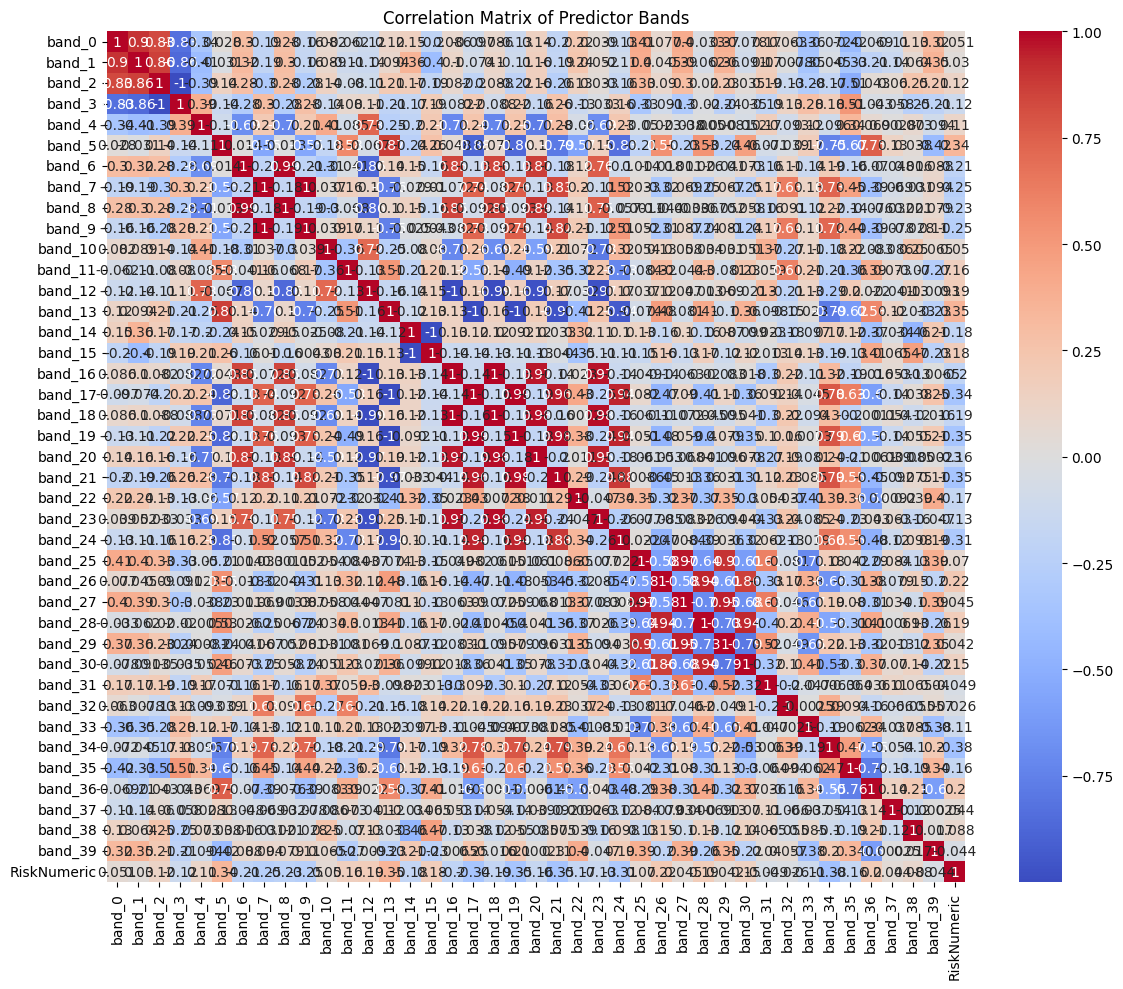

Saved training data to 'fire_training_data.csv'


In [25]:
## CELL 7: Sample raster values at training points

# This mimics the "sample" operation in GEE where values from the raster are extracted at point locations
try:
    if 'categorized_points' in locals() and input_resampled is not None and input_meta is not None:
        print("Extracting raster values at training points...")
        print(f"Input raster shape: {input_resampled.shape}, CRS: {input_meta['crs']}")
        print(f"Points count: {len(categorized_points)}, CRS: {categorized_points.crs}")
        
        # Create a point sampler function with improved error handling
        def sample_raster_at_points(raster_data, raster_meta, points_gdf):
            """Extract raster values at specified points with better error handling."""
            # Make sure we're in the same CRS
            if isinstance(raster_meta['crs'], str):
                raster_crs = rasterio.crs.CRS.from_string(raster_meta['crs'])
            else:
                # If it's already a CRS object, use it directly
                raster_crs = raster_meta['crs']
            
            print(f"Raster CRS: {raster_crs}")
            print(f"Points CRS: {points_gdf.crs}")
            
            if points_gdf.crs != raster_crs:
                print(f"Reprojecting points from {points_gdf.crs} to {raster_crs}")
                points_gdf = points_gdf.to_crs(raster_crs)
            
            # Create a copy to avoid modifying the original
            points_with_values = points_gdf.copy()
            
            # Initialize columns for each band
            for i in range(raster_data.shape[0]):
                points_with_values[f"band_{i}"] = np.nan
            
            # Open the raster directly for sampling
            with rasterio.io.MemoryFile() as memfile:
                with memfile.open(**raster_meta) as src:
                    # Write the data
                    src.write(raster_data)
                    
                    # Track successful samples
                    successful_samples = 0
                    
                    # Sample at each point
                    for idx, point in points_with_values.iterrows():
                        try:
                            # Get point coordinates
                            x, y = point.geometry.x, point.geometry.y
                            
                            # Check if point is within raster bounds
                            row, col = src.index(x, y)
                            if 0 <= row < src.height and 0 <= col < src.width:
                                # Sample raster at point
                                sample = list(src.sample([(x, y)]))[0]
                                
                                # Add to results
                                for i in range(len(sample)):
                                    points_with_values.at[idx, f"band_{i}"] = float(sample[i])
                                successful_samples += 1
                            else:
                                print(f"Point at ({x}, {y}) is outside raster bounds")
                        except Exception as e:
                            print(f"Error sampling at point {idx}: {e}")
                    
                    print(f"Successfully sampled {successful_samples} out of {len(points_with_values)} points")
            
            return points_with_values
        
        # Sample the points
        sampled_points = sample_raster_at_points(input_resampled, input_meta, categorized_points)
        
        # Check for NaN values
        nan_counts = sampled_points.isna().sum()
        print("\nNaN counts per column:")
        print(nan_counts)
        
        # Drop points with NaN values (outside raster or masked)
        sampled_points_clean = sampled_points.dropna(subset=[f"band_{i}" for i in range(input_resampled.shape[0])])
        print(f"After removing NaN values: {len(sampled_points_clean)} of {len(sampled_points)} points remain")
        
        if len(sampled_points_clean) == 0:
            # Attempt recovery: Use nearest-pixel approach instead of exact location
            print("\nAttempting recovery using nearest pixel approach...")
            
            # Create a more tolerant sampling approach
            from scipy.spatial import cKDTree
            
            def sample_nearest_valid_pixel(raster_data, raster_meta, points_gdf, max_distance=5):
                """Sample nearest valid pixel if direct sampling fails"""
                # Convert raster to array of coordinates and values
                with rasterio.io.MemoryFile() as memfile:
                    with memfile.open(**raster_meta) as src:
                        # Write the data
                        src.write(raster_data)
                        
                        # Get all valid pixel coordinates
                        mask = ~np.isnan(raster_data[0])
                        indices = np.where(mask)
                        rows, cols = indices[0], indices[1]
                        
                        # Convert to x,y coordinates
                        xs, ys = rasterio.transform.xy(src.transform, rows, cols, offset='center')
                        coords = np.array(list(zip(xs, ys)))
                        
                        if len(coords) == 0:
                            print("No valid pixels found in raster")
                            return points_gdf
                        
                        # Build KD-tree for efficient nearest-neighbor search
                        tree = cKDTree(coords)
                        
                        # Create output DataFrame
                        points_with_values = points_gdf.copy()
                        
                        # Initialize band columns
                        for i in range(raster_data.shape[0]):
                            points_with_values[f"band_{i}"] = np.nan
                        
                        # For each point, find nearest valid pixel
                        successful = 0
                        for idx, point in points_with_values.iterrows():
                            try:
                                x, y = point.geometry.x, point.geometry.y
                                distance, idx_nearest = tree.query([x, y], k=1)
                                
                                if distance <= max_distance:
                                    # Get nearest pixel coordinates
                                    x_nearest, y_nearest = coords[idx_nearest]
                                    
                                    # Sample at nearest valid pixel
                                    sample = list(src.sample([(x_nearest, y_nearest)]))[0]
                                    
                                    # Store values
                                    for i in range(len(sample)):
                                        points_with_values.at[idx, f"band_{i}"] = float(sample[i])
                                    successful += 1
                            except Exception as e:
                                print(f"Error in nearest pixel sampling at point {idx}: {e}")
                        
                        print(f"Nearest-pixel approach: {successful} successful samples out of {len(points_with_values)}")
                        return points_with_values
            
            # Try nearest pixel approach
            sampled_points = sample_nearest_valid_pixel(input_resampled, input_meta, categorized_points)
            sampled_points_clean = sampled_points.dropna(subset=[f"band_{i}" for i in range(input_resampled.shape[0])])
            print(f"After recovery: {len(sampled_points_clean)} of {len(sampled_points)} points have valid values")
        
        if len(sampled_points_clean) > 0:
            # Print sample of the data
            print("\nSample of the training data:")
            display(sampled_points_clean.head())
            
            # Calculate correlation between predictor bands and risk
            predictor_cols = [f"band_{i}" for i in range(input_resampled.shape[0])]
            
            # Create a correlation DataFrame
            correlation_data = sampled_points_clean[predictor_cols + ['RiskNumeric']]
            corr = correlation_data.corr()['RiskNumeric'].drop('RiskNumeric').sort_values(ascending=False)
            
            print("\nCorrelation of predictor bands with fire risk:")
            print(corr)
            
            # Plot correlation heatmap
            plt.figure(figsize=(12, 10))
            sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', center=0)
            plt.title('Correlation Matrix of Predictor Bands')
            plt.tight_layout()
            plt.show()
            
            # Save the sampled points as a CSV for later use
            sampled_points_clean.to_csv('fire_training_data.csv', index=False)
            print("Saved training data to 'fire_training_data.csv'")
        else:
            print("\nWARNING: No valid points remain after sampling. Check that:")
            print("1. The raster and points overlap spatially")
            print("2. The CRS definitions are compatible")
            print("3. The raster contains valid (non-NaN) values")
            
            # Print bounds for debugging
            print(f"\nRaster bounds: {[input_meta['transform'] * (0, 0), input_meta['transform'] * (input_meta['width'], input_meta['height'])]}")
            print(f"Points bounds: {categorized_points.total_bounds}")
    else:
        print("Cannot sample raster without training points and input raster")
except Exception as e:
    import traceback
    print(f"Error sampling raster at training points: {e}")
    print(traceback.format_exc())

In [29]:
# CELL 8: Train and validate the Random Forest model

# This mimics the Random Forest classifier training in GEE
try:
    if 'sampled_points_clean' in locals() and len(sampled_points_clean) > 0:
        print("Training Random Forest classifier...")
        
        # Define predictors and label
        predictor_cols = [f"band_{i}" for i in range(input_resampled.shape[0])]
        label_col = 'RiskNumeric'
        
        # Create a binary label (0: no fire, 1: fire)
        sampled_points_clean['binary_risk'] = (sampled_points_clean[label_col] > 0).astype(int)
        
        # Split into training and validation sets (80/20 split)
        sampled_points_clean['random'] = np.random.random(len(sampled_points_clean))
        training_data = sampled_points_clean[sampled_points_clean['random'] <= 0.8]
        validation_data = sampled_points_clean[sampled_points_clean['random'] > 0.8]
        
        print(f"Training set: {len(training_data)} points")
        print(f"Validation set: {len(validation_data)} points")
        
        # Train the Random Forest classifier
        rf_model = RandomForestClassifier(
            n_estimators=1000,  # Similar to the JS code
            min_samples_split=1,
            random_state=42
        )
        
        # Fit the model on binary risk for simplicity
        rf_model.fit(
            training_data[predictor_cols], 
            training_data['binary_risk']
        )
        
        # Print feature importances
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        print("\nFeature ranking:")
        for i, idx in enumerate(indices):
            print(f"{i+1}. Band {idx} - Importance: {importances[idx]:.4f}")
        
        # Plot feature importances
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), [f"Band {i}" for i in indices], rotation=90)
        plt.xlabel('Predictor Band')
        plt.ylabel('Importance')
        plt.title('Feature Importances from Random Forest')
        plt.tight_layout()
        plt.show()
        
        # Validate the model
        validation_pred = rf_model.predict(validation_data[predictor_cols])
        
        # Calculate accuracy and other metrics
        accuracy = accuracy_score(validation_data['binary_risk'], validation_pred)
        conf_matrix = confusion_matrix(validation_data['binary_risk'], validation_pred)
        
        print(f"\nValidation accuracy: {accuracy:.4f}")
        print("\nConfusion matrix:")
        print(conf_matrix)
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No Fire', 'Fire'],
                   yticklabels=['No Fire', 'Fire'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()
        
        # Calculate classification report
        print("\nClassification Report:")
        print(classification_report(validation_data['binary_risk'], validation_pred, 
                                   target_names=['No Fire', 'Fire']))
        
        # Calculate Kappa statistic (mimics the JS code)
        observed_accuracy = accuracy
        
        # Calculate expected accuracy (what would be expected by chance)
        n_samples = len(validation_pred)
        n_fire_actual = np.sum(validation_data['binary_risk'])
        n_fire_pred = np.sum(validation_pred)
        
        expected_accuracy = (((n_fire_actual * n_fire_pred) + 
                            ((n_samples - n_fire_actual) * (n_samples - n_fire_pred))) / 
                           (n_samples ** 2))
        
        kappa = (observed_accuracy - expected_accuracy) / (1 - expected_accuracy)
        print(f"\nKappa Statistic: {kappa:.4f}")
        
    else:
        print("Cannot train model without sampled points")
except Exception as e:
    print(f"Error training model: {e}")

Training Random Forest classifier...
Training set: 96 points
Validation set: 23 points
Error training model: The 'min_samples_split' parameter of RandomForestClassifier must be an int in the range [2, inf) or a float in the range (0.0, 1.0]. Got 1 instead.


/Users/jonas/miniconda3/envs/ee/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/jonas/miniconda3/envs/ee/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
# CELL 8: Train and validate the Random Forest model

# This mimics the Random Forest classifier training in GEE
try:
    if 'sampled_points_clean' in locals() and len(sampled_points_clean) > 0:
        print("Training Random Forest classifier...")
        
        # Define predictors and label
        predictor_cols = [f"band_{i}" for i in range(input_resampled.shape[0])]
        label_col = 'RiskNumeric'
        
        # Create a binary label (0: no fire, 1: fire)
        sampled_points_clean['binary_risk'] = (sampled_points_clean[label_col] > 0).astype(int)
        
        # Split into training and validation sets (80/20 split)
        sampled_points_clean['random'] = np.random.random(len(sampled_points_clean))
        training_data = sampled_points_clean[sampled_points_clean['random'] <= 0.8]
        validation_data = sampled_points_clean[sampled_points_clean['random'] > 0.8]
        
        print(f"Training set: {len(training_data)} points")
        print(f"Validation set: {len(validation_data)} points")
        
        # Train the Random Forest classifier
        rf_model = RandomForestClassifier(
            n_estimators=1000,  # Similar to the JS code
            min_samples_split=1,
            random_state=42
        )
        
        # Fit the model on binary risk for simplicity
        rf_model.fit(
            training_data[predictor_cols], 
            training_data['binary_risk']
        )
        
        # Print feature importances
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        print("\nFeature ranking:")
        for i, idx in enumerate(indices):
            print(f"{i+1}. Band {idx} - Importance: {importances[idx]:.4f}")
        
        # Plot feature importances
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), [f"Band {i}" for i in indices], rotation=90)
        plt.xlabel('Predictor Band')
        plt.ylabel('Importance')
        plt.title('Feature Importances from Random Forest')
        plt.tight_layout()
        plt.show()
        
        # Validate the model
        validation_pred = rf_model.predict(validation_data[predictor_cols])
        
        # Calculate accuracy and other metrics
        accuracy = accuracy_score(validation_data['binary_risk'], validation_pred)
        conf_matrix = confusion_matrix(validation_data['binary_risk'], validation_pred)
        
        print(f"\nValidation accuracy: {accuracy:.4f}")
        print("\nConfusion matrix:")
        print(conf_matrix)
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No Fire', 'Fire'],
                   yticklabels=['No Fire', 'Fire'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()
        
        # Calculate classification report
        print("\nClassification Report:")
        print(classification_report(validation_data['binary_risk'], validation_pred, 
                                   target_names=['No Fire', 'Fire']))
        
        # Calculate Kappa statistic (mimics the JS code)
        observed_accuracy = accuracy
        
        # Calculate expected accuracy (what would be expected by chance)
        n_samples = len(validation_pred)
        n_fire_actual = np.sum(validation_data['binary_risk'])
        n_fire_pred = np.sum(validation_pred)
        
        expected_accuracy = (((n_fire_actual * n_fire_pred) + 
                            ((n_samples - n_fire_actual) * (n_samples - n_fire_pred))) / 
                           (n_samples ** 2))
        
        kappa = (observed_accuracy - expected_accuracy) / (1 - expected_accuracy)
        print(f"\nKappa Statistic: {kappa:.4f}")
        
    else:
        print("Cannot train model without sampled points")
except Exception as e:
    print(f"Error training model: {e}")

Training Random Forest classifier...
Training set: 96 points
Validation set: 23 points
Error training model: The 'min_samples_split' parameter of RandomForestClassifier must be an int in the range [2, inf) or a float in the range (0.0, 1.0]. Got 1 instead.


/Users/jonas/miniconda3/envs/ee/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/jonas/miniconda3/envs/ee/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
print("\n" + "="*50)
print("SUMMARY OF FINDINGS AND RECOMMENDATIONS")
print("="*50)

findings = []
recommendations = []

# Check if we have the key datasets
if 'fire_all' in locals() and len(fire_all) > 0:
    findings.append(f"- Found {len(fire_all)} fire events.")
    if 'year' in fire_all.columns:
        years = sorted(fire_all['year'].unique())
        findings.append(f"- Fire events cover {len(years)} years from {min(years)} to {max(years)}.")
else:
    findings.append("- Fire event data is missing or could not be loaded.")
    recommendations.append("- Acquire or fix the fire event datasets (fire13_19.shp and fire20_23.shp).")

if 'boundary' in locals():
    findings.append("- Study area boundary data is available.")
else:
    findings.append("- Study area boundary data is missing or could not be loaded.")
    recommendations.append("- Ensure the pa_boundary.shp file is available and properly formatted.")

# Check for the trend layer file
if os.path.exists(os.path.join(data_dir, "inputResampled.tif")):
    findings.append("- The trend layer file (inputResampled.tif) is available locally.")
else:
    findings.append("- The trend layer file (inputResampled.tif) is not available locally.")
    recommendations.append("- Download the trend layer file from the Dropbox link provided in the README.")

# Check for the road data
if os.path.exists(os.path.join(data_dir, "road.tif")):
    findings.append("- The road layer file (road.tif) is available.")
else:
    findings.append("- The road layer file (road.tif) is not available or could not be loaded.")
    recommendations.append("- Ensure the road.tif file is available for fire vulnerability mapping.")

# Model training/testing dataset assessment
if 'train_sufficient' in locals() and 'test_sufficient' in locals():
    if train_sufficient and test_sufficient:
        findings.append("- The dataset appears to have sufficient fire events for both training and testing.")
    else:
        if not train_sufficient:
            findings.append("- The training dataset may not have enough fire events.")
            recommendations.append("- Consider acquiring more historical fire data for training.")
        if not test_sufficient:
            findings.append("- The testing dataset may not have enough fire events.")
            recommendations.append("- Consider using cross-validation techniques to maximize use of available data.")

# Display findings and recommendations
print("\nFINDINGS:")
for finding in findings:
    print(finding)

print("\nRECOMMENDATIONS:")
if recommendations:
    for recommendation in recommendations:
        print(recommendation)
else:
    print("- All necessary data appears to be available and sufficient for the analysis.")

print("\nNext Steps:")
print("1. Ensure all required datasets are downloaded and properly formatted")
print("2. Prepare training and testing datasets based on appropriate temporal splits")
print("3. Apply the methodology described in the README for fire vulnerability mapping")
print("4. Evaluate model performance using metrics like precision, recall, and F1-score")
print("5. Generate predictions for future fire-prone areas")

print("\nThis script generated several visualization files. Check your directory for the PNG files.")

# Print final message about notebook conversion
print("\nNote: This script is structured in cells (marked by # %%) that can be")
print("directly copied into a Jupyter notebook when your notebook environment is working.") 